In [1]:
import cv2
import numpy as np
import imgaug as ia 

In [5]:
def dice_coef(img, img2):
        if img.shape != img2.shape:
            raise ValueError("Shape mismatch: img and img2 must have to be of the same shape.")
        
        else:
            lenIntersection=0
            for i in range(img.shape[0]):
                for j in range(img.shape[1]):
                    if (np.array_equal(img[i][j],img2[i][j])):
                        lenIntersection+=1
             
            lenimg=img.shape[0]*img.shape[1]
            lenimg2=img2.shape[0]*img2.shape[1]  
            value = (2. * lenIntersection  / (lenimg + lenimg2))
        return value

def iou_coef(inputs, target, smooth=1):
    intersection = (target * inputs).sum()
    union = target.sum() + inputs.sum() - intersection
    iou = np.sum(intersection) / np.sum(union)
    return iou

def iou(prediction, target):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def dice(pred, true, k = 1):
    intersection = np.sum(pred[true==k]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

In [3]:
def pixel_accuracy(eval_segm, gt_segm):
    '''
    sum_i(n_ii) / sum_i(t_i)
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl = extract_classes(gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    sum_n_ii = 0
    sum_t_i  = 0

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]

        sum_n_ii += np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        sum_t_i  += np.sum(curr_gt_mask)
 
    if (sum_t_i == 0):
        pixel_accuracy_ = 0
    else:
        pixel_accuracy_ = sum_n_ii / sum_t_i

    return pixel_accuracy_

def mean_accuracy(eval_segm, gt_segm):
    '''
    (1/n_cl) sum_i(n_ii/t_i)
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl = extract_classes(gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    accuracy = list([0]) * n_cl

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]

        n_ii = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        t_i  = np.sum(curr_gt_mask)
 
        if (t_i != 0):
            accuracy[i] = n_ii / t_i

    mean_accuracy_ = np.mean(accuracy)
    return mean_accuracy_

def mean_IU(eval_segm, gt_segm):
    '''
    (1/n_cl) * sum_i(n_ii / (t_i + sum_j(n_ji) - n_ii))
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl   = union_classes(eval_segm, gt_segm)
    _, n_cl_gt = extract_classes(gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    IU = list([0]) * n_cl

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]
 
        if (np.sum(curr_eval_mask) == 0) or (np.sum(curr_gt_mask) == 0):
            continue

        n_ii = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        t_i  = np.sum(curr_gt_mask)
        n_ij = np.sum(curr_eval_mask)

        IU[i] = n_ii / (t_i + n_ij - n_ii)
 
    mean_IU_ = np.sum(IU) / n_cl_gt
    return mean_IU_

def frequency_weighted_IU(eval_segm, gt_segm):
    '''
    sum_k(t_k)^(-1) * sum_i((t_i*n_ii)/(t_i + sum_j(n_ji) - n_ii))
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl = union_classes(eval_segm, gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    frequency_weighted_IU_ = list([0]) * n_cl

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]
 
        if (np.sum(curr_eval_mask) == 0) or (np.sum(curr_gt_mask) == 0):
            continue

        n_ii = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        t_i  = np.sum(curr_gt_mask)
        n_ij = np.sum(curr_eval_mask)

        frequency_weighted_IU_[i] = (t_i * n_ii) / (t_i + n_ij - n_ii)
 
    sum_k_t_k = get_pixel_area(eval_segm)
    
    frequency_weighted_IU_ = np.sum(frequency_weighted_IU_) / sum_k_t_k
    return frequency_weighted_IU_

'''
Auxiliary functions used during evaluation.
'''
def get_pixel_area(segm):
    return segm.shape[0] * segm.shape[1]

def extract_both_masks(eval_segm, gt_segm, cl, n_cl):
    eval_mask = extract_masks(eval_segm, cl, n_cl)
    gt_mask   = extract_masks(gt_segm, cl, n_cl)

    return eval_mask, gt_mask

def extract_classes(segm):
    cl = np.unique(segm)
    n_cl = len(cl)

    return cl, n_cl

def union_classes(eval_segm, gt_segm):
    eval_cl, _ = extract_classes(eval_segm)
    gt_cl, _   = extract_classes(gt_segm)

    cl = np.union1d(eval_cl, gt_cl)
    n_cl = len(cl)

    return cl, n_cl

def extract_masks(segm, cl, n_cl):
    h, w  = segm_size(segm)
    masks = np.zeros((n_cl, h, w))

    for i, c in enumerate(cl):
        masks[i, :, :] = segm == c

    return masks

def segm_size(segm):
    try:
        height = segm.shape[0]
        width  = segm.shape[1]
    except IndexError:
        raise

    return height, width

def check_size(eval_segm, gt_segm):
    h_e, w_e = segm_size(eval_segm)
    h_g, w_g = segm_size(gt_segm)

    if (h_e != h_g) or (w_e != w_g):
        raise EvalSegErr("DiffDim: Different dimensions of matrices!")

In [18]:
diretorio = "../../../daninhas/dataset/analise/"
objective = diretorio + 'daninha_262_filter.jpg'
objective = cv2.imread(objective, cv2.IMREAD_COLOR)

result = diretorio + 'daninha_262_maske_pred.jpg'
result = cv2.imread(result, cv2.IMREAD_COLOR)

UiP(result, objective)

0.9672

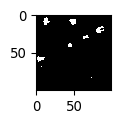

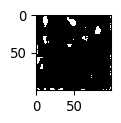

Contagem de Zeros Corretos    : 283
Contagem de Zeros da Predição : 525


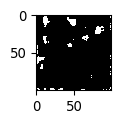

Contagem da União de Pixels : 611


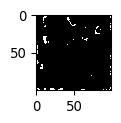

Contagem de Pixels errados:  328 

Porcentagem de acertos:  0.9672
iou_coef 0.0009570400742313316
IoU 0.32242225859247137
frequency_weighted_IU 0.9397877448584911
dice 0.4876237623762376
dice_coef 0.9586


In [16]:

diretorio = "../../../daninhas/dataset/analise/"
objective = diretorio + 'daninha_262_filter.jpg'
objective = cv2.imread(objective, cv2.IMREAD_COLOR)

def UiP(pred, true):
    pred = cv2.cvtColor(pred, cv2.COLOR_BGR2GRAY)
    (thresh, pred) = cv2.threshold(pred, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    true = cv2.cvtColor(true, cv2.COLOR_BGR2GRAY)
    (thresh, true) = cv2.threshold(true, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    union = np.logical_or(pred, true)
    union = union.astype(np.uint8) * 255
    dif = cv2.subtract(union, true)

    return (1-cv2.countNonZero(dif) / dif.size)
        
def metrics(pred, true):
    print('UiP : ', UiP(pred, true))
        print('UiP : ', UiP(pred, true))
objective = cv2.cvtColor(objective, cv2.COLOR_BGR2GRAY)

(thresh, objective) = cv2.threshold(objective, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

ia.imshow(objective)   

result = diretorio + 'daninha_262_maske_pred.jpg'
result = cv2.imread(result, cv2.IMREAD_COLOR)
result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

(thresh, result) = cv2.threshold(result, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

ia.imshow(result)   

#result = result.astype('uint8')

print('Contagem de Zeros Corretos    :', cv2.countNonZero(objective))
print('Contagem de Zeros da Predição :', cv2.countNonZero(result))

union = np.logical_or(result, objective)
union = union.astype(np.uint8) * 255

ia.imshow(union)
print('Contagem da União de Pixels :', cv2.countNonZero(union))

dif = cv2.subtract(union, objective)
ia.imshow(dif)
print('Contagem de Pixels errados: ', cv2.countNonZero(dif), '\n')

print('Porcentagem de acertos: ', 1-cv2.countNonZero(dif) / dif.size)
print('iou_coef', iou_coef(result, objective))
print('IoU', iou(result, objective))
print('frequency_weighted_IU', frequency_weighted_IU(result, objective))
print('dice', dice(result, objective, k = 255))
print('dice_coef', dice_coef(result, objective))